# Sentiment Analysis of Personal Statements

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Acquire" data-toc-modified-id="Acquire-3">Acquire</a></span></li><li><span><a href="#Word-Cloud" data-toc-modified-id="Word-Cloud-4">Word Cloud</a></span></li><li><span><a href="#Sentiment-Scoring" data-toc-modified-id="Sentiment-Scoring-5">Sentiment Scoring</a></span><ul class="toc-item"><li><span><a href="#Afinn" data-toc-modified-id="Afinn-5.1">Afinn</a></span></li><li><span><a href="#vaderSentiment" data-toc-modified-id="vaderSentiment-5.2">vaderSentiment</a></span></li><li><span><a href="#Relationship-Between-Scores" data-toc-modified-id="Relationship-Between-Scores-5.3">Relationship Between Scores</a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-5.4">Scaling</a></span></li><li><span><a href="#Average" data-toc-modified-id="Average-5.5">Average</a></span></li></ul></li><li><span><a href="#Exploration" data-toc-modified-id="Exploration-6">Exploration</a></span><ul class="toc-item"><li><span><a href="#Most-Positive-and-Negative-Words" data-toc-modified-id="Most-Positive-and-Negative-Words-6.1">Most Positive and Negative Words</a></span></li></ul></li></ul></div>

## Imports

In [1]:
import json
from copy import deepcopy
from functools import reduce
import unicodedata
import re
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler

## Functions

In [2]:
# applies in the order supplied
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)

def map_exhaust(func, *iters):
    for args in zip(*iters):
        func(*args)
        
def normalize_text(text):
    return (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )

def remove_chars(text):
    return re.sub(r"[^A-Za-z0-9 ]", "", re.sub(r"\s", " ", text))

def basic_clean(text):
    return pipe(text, str.lower, normalize_text, remove_chars)

def tokenize(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text, return_str=True)

def remove_stopwords(text, include=[], exclude=[]):
    stopword_list = stopwords.words("english")

    map_exhaust(stopword_list.remove, exclude)
    map_exhaust(stopword_list.append, include)

    removed = " ".join([w for w in text.split() if w not in stopword_list])

    #     print("Removed", len(text.split()) - len(removed.split()), "words")
    return removed

def lemmatize(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(lemmas)

def prep_statement(statement_data):
    copy = deepcopy(statement_data)

    copy["clean"] = pipe(
        copy["personal_statement"],
        basic_clean,
        tokenize,
        remove_stopwords
    )

    copy["lemmatized"] = lemmatize(copy["clean"])

    return copy

def prep_statements(statements_data):
    return [prep_statement(statement) for statement in ps_json]

## Acquire

In [3]:
with open("personal_statements_2019-05-17.json", "r") as fp:
    ps_json = json.load(fp)

In [4]:
df = pd.DataFrame(prep_statements(ps_json)).set_index("name")

In [5]:
df.head()

,clean,lemmatized,personal_statement
name,,,
Jason Dunn,retired marine officer career field logistics ...,retired marine officer career field logistics ...,"As a retired Marine Officer, my career field w..."
Chad Hackney,thorough detailfocused data scientist creates ...,thorough detailfocused data scientist creates ...,"Thorough, detail-focused data scientist who cr..."
Eric Escalante,key contributor multifaceted teams identify as...,key contributor multifaceted team identify ass...,I am a key contributor for multifaceted teams ...
Ednalyn C. De Dios,ive always enamored code love data science inh...,ive always enamored code love data science inh...,I’ve always been enamored with code and I love...
Sandy Graham,happiest allowed curious researching understan...,happiest allowed curious researching understan...,I am happiest when I am allowed to be curious....


## Word Cloud

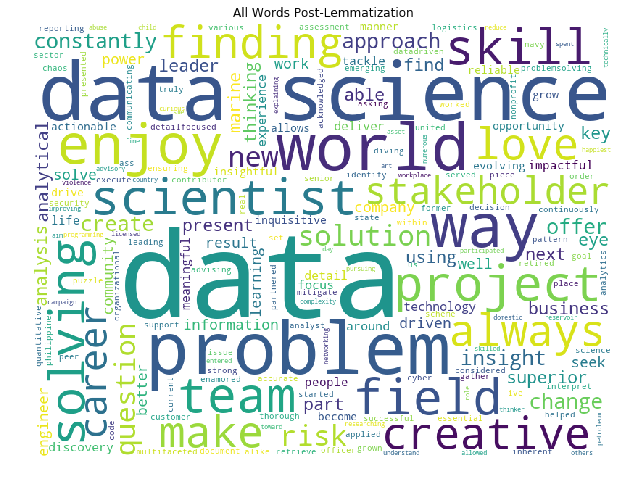

In [6]:
all_text = " ".join(df.lemmatized)

plt.figure(figsize=(12, 8))
cloud = WordCloud(
    background_color="white", height=600, width=800
).generate(all_text)
plt.title("All Words Post-Lemmatization")
plt.axis("off")
plt.imshow(cloud)

## Sentiment Scoring

### Afinn

In [7]:
afinn = Afinn()

In [8]:
df = df.assign(afinn_score=df.personal_statement.apply(afinn.score))

In [9]:
df = df.sort_values(by="afinn_score", ascending=False)

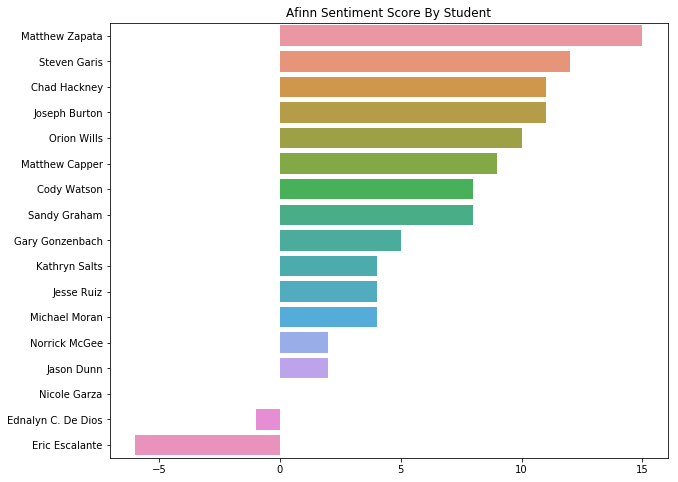

In [10]:
plt.figure(figsize=(10, 8))
sns.barplot(x="afinn_score", y=df.index, data=df, orient="h")
plt.title("Afinn Sentiment Score By Student")
plt.xlabel("")
plt.ylabel("")
plt.show()

### vaderSentiment

compound score: -1 is most negative and +1 is most positive (*see* https://github.com/cjhutto/vaderSentiment)

In [11]:
vader = SentimentIntensityAnalyzer()

In [12]:
df = df.assign(vader_score=df.personal_statement.apply(lambda text: vader.polarity_scores(text)["compound"]))

### Relationship Between Scores

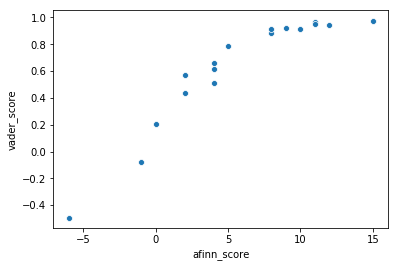

In [13]:
sns.scatterplot(x="afinn_score", y="vader_score", data=df)
plt.show()

The relationship appears to be cubic, with asymptotes at +1 and -1.

### Scaling

Min-max scale the Afinn score. After scaling the Afinn score, the highest will be 1, which is close to vader's highest of 0.98.

In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [15]:
scaler.fit(df[["afinn_score"]])

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [16]:
scaler.transform(df[["afinn_score"]])

array([[ 1.        ],
       [ 0.71428571],
       [ 0.61904762],
       [ 0.61904762],
       [ 0.52380952],
       [ 0.42857143],
       [ 0.33333333],
       [ 0.33333333],
       [ 0.04761905],
       [-0.04761905],
       [-0.04761905],
       [-0.04761905],
       [-0.23809524],
       [-0.23809524],
       [-0.42857143],
       [-0.52380952],
       [-1.        ]])

In [17]:
df = df.assign(afinn_score_scaled=scaler.transform(df[["afinn_score"]]))

Scaling is not the best approach because I automatically set the ceiling and floor when fitting. A score the scaler has not seen may blow the ceiling and render the -1 to 1 range meaningless as representing the absolute positive and absolute negative. On the other hand, if a text's scaled Afinn score is greater than 1 or less than -1, it means that text is the new most positive or negative text. For now, scaling is the easiest way to get these numbers in the same general area.

### Average

In [18]:
df = df.assign(avg_score=(df.afinn_score_scaled + df.vader_score) / 2)

## Exploration

In [19]:
df[["afinn_score", "afinn_score_scaled", "vader_score", "avg_score"]].sort_values(by=["afinn_score", "vader_score"], ascending=False)

,afinn_score,afinn_score_scaled,vader_score,avg_score
name,,,,
Matthew Zapata,15.0,1.000000,0.9771,0.988550
Steven Garis,12.0,0.714286,0.9460,0.830143
Chad Hackney,11.0,0.619048,0.9633,0.791174
Joseph Burton,11.0,0.619048,0.9507,0.784874
Orion Wills,10.0,0.523810,0.9169,0.720355
Matthew Capper,9.0,0.428571,0.9184,0.673486
Sandy Graham,8.0,0.333333,0.9169,0.625117
Cody Watson,8.0,0.333333,0.8834,0.608367
Gary Gonzenbach,5.0,0.047619,0.7906,0.419110


In [20]:
df.describe()

,afinn_score,vader_score,afinn_score_scaled,avg_score
count,17.000000,17.000000,17.000000,17.000000
mean,5.764706,0.628794,0.120448,0.374621
std,5.437479,0.416311,0.517855,0.458101
min,-6.000000,-0.493900,-1.000000,-0.746950
25%,2.000000,0.510600,-0.238095,0.166902
50%,5.000000,0.790600,0.047619,0.419110
75%,10.000000,0.918400,0.523810,0.720355
max,15.000000,0.977100,1.000000,0.988550


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


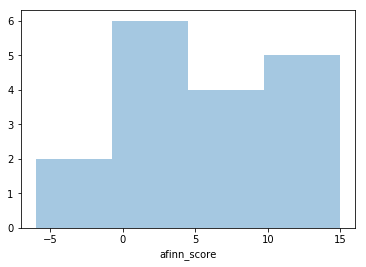

In [21]:
sns.distplot(df.afinn_score, kde=False)
plt.show()

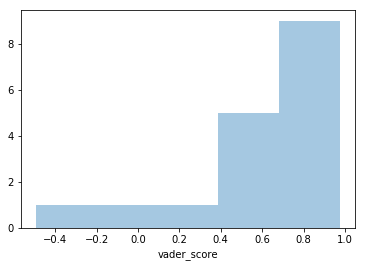

In [22]:
sns.distplot(df.vader_score, kde=False)
plt.show()

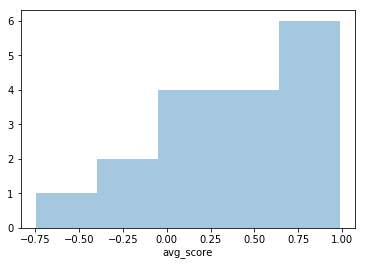

In [23]:
sns.distplot(df.avg_score, kde=False)
plt.show()

### Most Positive and Negative Words

Extract the words with dictionary matches and their valence scores

In [24]:
statements_by_person = [text for text in df.lemmatized]
scores_for_words = []
found_words = []
for statement in statements_by_person:
    scores_for_words += afinn.scores(statement)
    found_words += afinn.find_all(statement)

Put it all in a dataframe and drop the duplicate words

In [25]:
word_scores = pd.DataFrame({"word": found_words, "score": scores_for_words}).drop_duplicates("word")

**Most positive words**

In [26]:
word_scores.sort_values("score", ascending=False).head(10)

,word,score
8,amazing,4
30,great,3
49,happiest,3
20,successful,3
9,love,3
34,excellent,3
1,creative,2
31,opportunity,2
33,talent,2
35,ability,2


**Most negative words**

In [27]:
word_scores.sort_values("score").head(10)

,word,score
87,ass,-4
86,abuse,-3
85,violence,-3
88,risk,-2
3,problem,-2
18,chaos,-2
70,challenge,-1
40,exploration,1
39,grant,1
48,want,1


ass???